In [175]:
import pandas as pd
import matplotlib.pyplot as plt

In [176]:
plt.rcParams["figure.figsize"] = (15, 5)

**Import and prepare data**

Add extra columns

In [177]:
def prepare_data(coin):
    df = pd.read_csv(f'../data/coin_{coin}.csv', index_col=0).reset_index()
    df.Date = pd.to_datetime(df.Date)
    df['dayofweek'] = df.Date.dt.dayofweek
    df['dayofmonth'] = df.Date.dt.day
    df['year_month'] = df.Date.dt.strftime("%Y-%m")
    df['avg_daily_price']= (df.High + df.Low) / 2
    return df

**Calculate profit**

Given the provided dataframe for a specific coin, and the configuration for the frequency of the DCA plan, calculate the profit in percantage accumulated over the specified time window.

In [178]:
def calculate_profit_dca(df, frequency, purchase_year_month = '2018-01',\
                        purchase_day_of_week = 0, purchase_day_of_month = [0]):
    purchase_usd = 10
    if frequency == 'monthly':
        freq_cond = (df.dayofmonth.isin(purchase_day_of_month))
        if(31 in purchase_day_of_month):
            # Take last day of months with 30 days
            freq_cond = freq_cond | (df.Date.dt.month.isin([11,4,6,9]) & (df.dayofmonth == 30))
        if((31 in purchase_day_of_month) or (30 in purchase_day_of_month)):
            # Take last day of February (29th in case of leap year)
            freq_cond = freq_cond |\
                        (df.Date.dt.year.isin([2008, 2012, 2016, 2020, 2024, 2028, 2032, 2036, 2040, 2044]) &\
                         df.Date.dt.month.isin([2]) & (df.dayofmonth == 29))
        if((31 in purchase_day_of_month) or (30 in purchase_day_of_month) or (29 in purchase_day_of_month)):     
            # In case 29 is the day, use 28 for February in non leap year
            freq_cond = freq_cond |\
                        ((~df.Date.dt.year.isin([2008, 2012, 2016, 2020, 2024, 2028, 2032, 2036, 2040, 2044])) &\
                         df.Date.dt.month.isin([2]) & (df.dayofmonth == 28))          
    if frequency == 'weekly':
        freq_cond = (df.dayofweek == purchase_day_of_week)

    purchase = df[(df.year_month >= purchase_year_month) & freq_cond]
    purchased_amount = (purchase_usd/purchase.High).sum()
    investment_amount = purchase_usd * len(purchase)
    investment_value = df[-1:].High * purchased_amount
    return (investment_value / investment_amount) *100

The considered coins

In [179]:
coins = ['Ethereum', 'Cardano', 'Polkadot']
coin_weights = {'Ethereum': 60,
                'Cardano':20,
                'Polkadot':20}

In [180]:
coin_sample_size = {}

Calculate profits for each combination of days of the month, given a biweekly DCA

In [181]:
days_of_month_profit = {'day': []}
for i in range(0,32):
    for j in range(i+1,32):
        days_of_month_profit['day'].append(f"{i}-{j}")

for coin in coins:
    df = prepare_data(coin)
    days_of_month_profit[coin] = []
    coin_sample_size[coin] = df.year_month.nunique()
    print(f"Calculating profit for coin {coin}. Sample size {df.year_month.nunique()}...")
    for i in range(0,32):   
        for j in range(i+1,32):
            days_of_month_profit[coin].append(calculate_profit_dca(df, 'monthly', purchase_day_of_month=[i,j]).iloc[0])

Calculating profit for coin Ethereum. Sample size 72...
Calculating profit for coin Cardano. Sample size 46...
Calculating profit for coin Polkadot. Sample size 12...


In [182]:
profit_df = pd.DataFrame(days_of_month_profit).set_index('day')

Define weights for each coin, to adjust its impact on the identification of the most profitable combination of days

In [183]:
def weightedValue(row):
    val = 0
    for coin, weight in coin_weights.items():
        val = val + row[coin] * (weight + (coin_sample_size[coin]/sum(coin_sample_size.values()))/2)
    return val

Use ranks to order the best combinations and sum them according to the weights. We also weight the contribution according to the sample size. Coins for which we have fewer observations will weight less since their profits are less trustworthy.

In [184]:
profit_df['best_profit_scores'] = profit_df.rank().transpose()\
         .apply(weightedValue)

<AxesSubplot:xlabel='invesment_days', ylabel='z-score profit'>

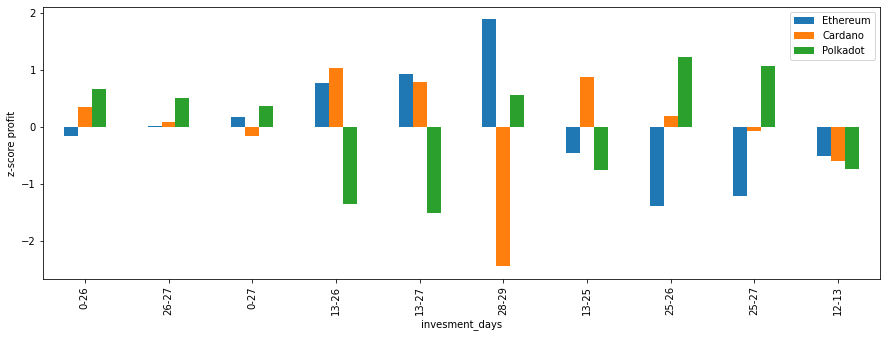

In [185]:
tmp_df = profit_df.sort_values(by='best_profit_scores',ascending=False).head(10)\
         .drop(columns='best_profit_scores')
plt = ((tmp_df - tmp_df.mean())/tmp_df.std()).plot(kind='bar', ylabel='z-score profit', xlabel='invesment_days')
plt.get_figure().savefig("../images/portfolio_twice_a_month.jpeg", bbox_inches = 'tight',
    pad_inches = 0.2)
plt

The results suggest that for the coins in question, the best combination of days is 0-26. However it is interesting to observe that the top 10 combinations include 3 dates ranges:
* The first day of the month
* The middle of the month, with the 13th and 14th days
* Close to the end of the month, with the 27th and 28th days

This suggests that half way through the month and right before the end are a good spot to buy, even twice. Otherwise it is better to distantiate the purchases by more than two weeks, either starting at the beginning and buying right before the end, or buying in the middle and before the end.

In [186]:
profit_df['best_profit_scores'].idxmax()

'0-26'

The pair that maximises the profits is 0-26 (first day of the month and the 27th).